# The Case for Using an Embedding Encoder

It's a common practice to use pre-trained word embeddings to jump start an NLP classifier's performance. The embeddings can be further updated during training (if they aren't frozen) and this can lead to even better performance. If an unseen word is encountered (usually called OOV, out of vocabulary), typically a new embedding row is added. Typically, there are three main strategies for initializing the row's values:
* random values
* zeros
* random values seeded with the matrix's variance for each corresponding column

We'll examine these approaches, and propose a new method, where we train a regression model to predict the row values. Of course, a regression model isn't going to replace the training of embeddings, however, we'll see that it may significantly jump start the seeding values better than the typical approaches. 

The regression model approach, although elementary, has escaped some recent research:

e.g. "we do not see any significant difference between various methods of random initialization, as long as the variance is kept reasonably low." 

An Exploration of Word Embedding Initialization in Deep-Learning Tasks Tom Kocmi and Ondˇrej Bojar, https://arxiv.org/pdf/1711.09160.pdf

### Concrete Task: find which word embeddings are in GoogleNews but not in Glove, train an encoder to create suitable initializations, instead of using random values

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
from random import sample
from statistics import mean, stdev

from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import numpy as np 

import os
import sys
import inspect
from pathlib import Path 
currentdir = Path.cwd()
# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from mlyoucanuse.embeddings import (load_embeddings, EMBEDDINGS_METADATA,
                                    create_embeddings_matrix, 
                                    get_embeddings_layer, 
                                    get_embeddings_index)
from mlyoucanuse.featurize_text_fun import word_to_features

seed = 12
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Using TensorFlow backend.


## Load Glove Embeddings, extract vocab, sample

In [2]:
print(f"Available embeddings: {', '.join(list(EMBEDDINGS_METADATA.keys()))}")

glove_embed = get_embeddings_index('glove', parent_dir=parentdir, embedding_dimensions=300)
glove_vocab = {tmp for tmp in tqdm(glove_embed.keys())}
sample(glove_vocab, 5)

Available embeddings: glove, GoogleNews, CommonCrawl.840B, Twitter2B, CommonCrawl.42B


100%|██████████| 400000/400000 [00:00<00:00, 1864709.03it/s]


['53.02', 'zumba', 'charal', 'sørland', 'acceptances']

## Determine the max sequence length so we can model it.

In [3]:
max_word_len = max([len(tmp) for tmp in glove_embed.keys()])
max_word_len

68

## Load GoogleNews embeddings, extract vocab, sample

In [4]:
gnews_embed = get_embeddings_index('GoogleNews', parent_dir=parentdir, embedding_dimensions=300)
gnews_vocab = {tmp for tmp in tqdm(gnews_embed.keys())} 
sample(gnews_vocab, 5)

100%|██████████| 3000000/3000000 [00:01<00:00, 1866487.72it/s]


['OPPOSITION_Leader_Kevin_Rudd',
 'illegal_file_sharers',
 'Girls_Allowed',
 'puede_phrase',
 'Robert_Daski']

In [5]:
sum_underscores = sum([1 for tmp in gnews_vocab if '_' in tmp])
print(f"GoogleNews keys with underscores: {sum_underscores:,}, {sum_underscores / len(gnews_vocab):.2f}%")

sum_underscores = sum([1 for tmp in glove_vocab if '_' in tmp])
print(f"Glove keys with underscores: {sum_underscores:,} {sum_underscores / len(glove_vocab):.2f}%")

GoogleNews keys with underscores: 2,070,978, 0.69%
Glove keys with underscores: 460 0.00%


In [6]:
gnews_vocab_single_words = {tmp for tmp in gnews_vocab if '_' not in tmp}
glove_vocab_single_words = {tmp for tmp in glove_vocab if '_' not in tmp}
glove_single_word_embeddings = [val for key, val in glove_embed.items() if '_' not in key]

In [7]:
only_in_gnews = gnews_vocab_single_words - glove_vocab_single_words # use set subtraction to find the missing words
print(f"Number of single words in GoogleNews: {len(only_in_gnews):,}")
sample(only_in_gnews, 5)

Number of single words in GoogleNews: 823,064


['TVNow', 'Rajcok', 'COUNTRIES', 'Roboteq', 'unsubscribing']

### Manual sampling and selection produced these only_in_gnews favorites: 
* resuspension
* comments
* devourers
* stickbait

### Capitalized words are usually entities; let's extract lower case candidates since relative words for comparison will be easier to find.

In [8]:
lc_only_in_gnews = {tmp for tmp in only_in_gnews if tmp.islower()}
sample(lc_only_in_gnews, 5)

['www.dea.com', 'www.lucent.com', 'iotum', 'meeet', 'boluses']

### Manual sampling and review selected these suitable candidates:
* underserviced
* guitaring
* wholesomely
* redevelops
* enkindle
* mooched
* wattages

## Check that are candidates and near matches are available in the target embeddding

In [9]:
print('underserviced' in only_in_gnews, 'underservice' in glove_vocab_single_words)
some_words_only_in_gnews = [    
    'resuspension', 
    'devourers',    
    'underserviced',
    'guitaring',
    'wholesomely', 
    'redevelops',
    'enkindle',
    'mooched',
    'wattages',
    'hellaciously', 
    'pouters',
    'flushers']

for word in some_words_only_in_gnews:
    if word not in only_in_gnews:
        print(word)

analogous_words_in_glove =[     
    'suspension',    
    'devour',    
    'underserved',
    'guitar',
    'wholesome',
    'redevelop',
    'kindle',
    'mooch',
    'wattage',
    'hellacious',
    'pout',
    'flusher']                            
for word in analogous_words_in_glove:
    if word not in glove_vocab_single_words:
        print(word)
# not found microcrack, pouter

True False


# Define the data and data loader

In [10]:
X = [word_to_features((word + ' '*70)[:70], max_word_length=70, reverse=False) 
     for word in list(glove_vocab_single_words)]   

y = glove_single_word_embeddings

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float)
print('X_train', X_train.shape)
y_train = torch.tensor(y_train)
print('y_train', y_train.shape)
X_test = torch.tensor(X_test, dtype=torch.float)
print('X_test', X_test.shape)
y_test = torch.tensor(y_test)
print('y_test', y_test.shape)

batch_size = 64
epochs = 3
learning_rate = 1e-3

train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i], y_train[i]])
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

X_train torch.Size([379563, 70])
y_train torch.Size([379563, 300])
X_test torch.Size([19977, 70])
y_test torch.Size([19977, 300])


# Define model and train to generate embeddings

Other model architectures were tried, but this was the most performant

In [11]:
class EmbeddingEncoder(nn.Module):
    def __init__(self, input_shape=70, embedding_size=300, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(in_features=input_shape, out_features=embedding_size)
        self.encoder_output_layer = nn.Linear(in_features=embedding_size, out_features=embedding_size)

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        return code

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmbeddingEncoder(input_shape=70, embedding_size=300).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
model.train()

for epoch in range(epochs): 
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data   
        inputs.to(device)
        labels.to(device)
        optimizer.zero_grad() #: zero the parameter gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % (batch_size * 10) == 0: # print every 100 mini-batches
            print('[epoch %d, batch %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / (batch_size *10)  ) )
            running_loss = 0.0
print('Finished Training')

[epoch 1, batch     1] loss: 0.114
[epoch 1, batch   641] loss: 40.060
[epoch 1, batch  1281] loss: 24.410
[epoch 1, batch  1921] loss: 7.743
[epoch 1, batch  2561] loss: 2.997
[epoch 1, batch  3201] loss: 2.233
[epoch 1, batch  3841] loss: 0.386
[epoch 1, batch  4481] loss: 0.378
[epoch 1, batch  5121] loss: 1.125
[epoch 1, batch  5761] loss: 1.477
[epoch 2, batch     1] loss: 0.000
[epoch 2, batch   641] loss: 15.132
[epoch 2, batch  1281] loss: 0.190
[epoch 2, batch  1921] loss: 0.162
[epoch 2, batch  2561] loss: 0.176
[epoch 2, batch  3201] loss: 0.170
[epoch 2, batch  3841] loss: 0.155
[epoch 2, batch  4481] loss: 0.170
[epoch 2, batch  5121] loss: 0.145
[epoch 2, batch  5761] loss: 0.160
[epoch 3, batch     1] loss: 0.000
[epoch 3, batch   641] loss: 0.133
[epoch 3, batch  1281] loss: 0.137
[epoch 3, batch  1921] loss: 0.134
[epoch 3, batch  2561] loss: 0.137
[epoch 3, batch  3201] loss: 0.132
[epoch 3, batch  3841] loss: 0.135
[epoch 3, batch  4481] loss: 15.947
[epoch 3, batch 

# Verify with the test set
## Our metric will be Cosine similarity; so the lower the percent score, the better

In [12]:
y_pred = []
model.eval()
with torch.no_grad():
    for idx, x in enumerate(X_test):
        the_pred = model(x)
        y_pred.append(the_pred)

scores = [cosine(y_pred[idx], sample) for sample in y_test]
mean(scores), stdev(scores)
# (0.679192502973701, 0.15922573805486012)

(0.6790134483879718, 0.15936205216074567)

# Similarity scores for default initializations, rows of all ones

In [13]:
ones = torch.ones(300, dtype=torch.float)
scores = [cosine(ones, sample) for sample in glove_embed.values()] 
mean(scores), stdev(scores)

(1.0110054014078103, 0.0561741914288907)

# Similarity scores for default initializations, rows of almost zeros

In [14]:
almost_zeros = torch.tensor([0.1e-3] * 300)
scores = [cosine(almost_zeros, sample) for sample in glove_embed.values()] 
mean(scores), stdev(scores)

(1.0110054011660812, 0.056174190174417875)

# Similarity scores for matrix rows initialized to random values centered on the variance of the embedding

In [15]:
cols = list(glove_embed.values())[0].shape[0]
embed_ar = np.asarray(list(glove_embed.values()))
matrix_variance = np.asarray([np.var(embed_ar[:, idx]) for idx in range(cols)])
del embed_ar, cols
scores = [cosine(torch.tensor(matrix_variance * np.random.rand(1, 300)),
                 sample) for sample in y_test]
mean(scores), stdev(scores)    

(1.0017122539355887, 0.05685415286427995)

In [16]:
# Save and load if desired
# torch.save(model, 'glove_embedding_encoder.pth') 
# model = torch.load( 'glove_embedding_encoder.pth')

# Here's an example of the matrix values we're trying to approximate

In [17]:
print(cosine(glove_embed['presidents'], glove_embed['president']))

0.35078948736190796


In [18]:
print(cosine(gnews_embed['presidents'], gnews_embed['president']))

0.4403637647628784


## Even with the same word, with the difference being singular or plural, there's still some fair amount of difference between their representations.

In [19]:
analogous_words_in_glove

['suspension',
 'devour',
 'underserved',
 'guitar',
 'wholesome',
 'redevelop',
 'kindle',
 'mooch',
 'wattage',
 'hellacious',
 'pout',
 'flusher']

## Let's visualize the generated embedding initializations
we'll use TSNE to get a visual representation; reducing the dimensionality from 300 to 2 won't give us an exact comparison, but it should allow us to see if we're in the ballpark. 

[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.000s...
[t-SNE] Computed neighbors for 26 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 26 / 26
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 56.9380188, gradient norm = 0.5224843 (50 iterations in 0.019s)
[t-SNE] Iteration 100: error = 57.3133507, gradient norm = 0.4613132 (50 iterations in 0.018s)
[t-SNE] Iteration 150: error = 53.1056862, gradient norm = 0.4914672 (50 iterations in 0.023s)
[t-SNE] Iteration 200: error = 51.8919334, gradient norm = 0.4598358 (50 iterations in 0.035s)
[t-SNE] Iteration 250: error = 60.2063675, gradient norm = 0.2621924 (50 iterations in 0.026s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.206367
[t-SNE] Iteration 300: error = 0.6627942, gradient norm = 0.0024780 (50 iterations in 0.021s)
[t-SNE] Iteration 350: error = 0.4528618, gradient norm = 0.0014517 (50 i

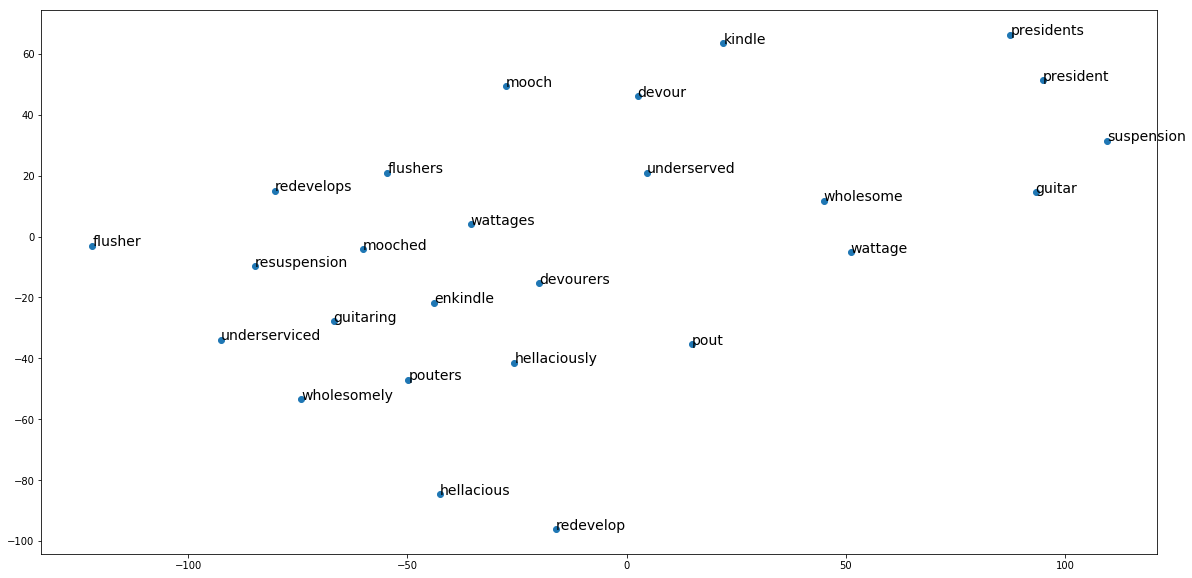

In [20]:
X_to_find = [word_to_features((word + ' '*70)[:70], max_word_length=70, reverse=False) 
     for word in some_words_only_in_gnews]   
X_to_find = torch.tensor(X_to_find, dtype=torch.float)

old_and_new_words ={}

for word in analogous_words_in_glove:
    old_and_new_words[word] = glove_embed[word]

old_and_new_words['president'] = glove_embed['president']
old_and_new_words['presidents'] = glove_embed['presidents']

model.eval()
with torch.no_grad():
    for idx, x in enumerate(X_to_find):
        old_and_new_words[some_words_only_in_gnews[idx]] = model(x).detach().numpy()

items = list(old_and_new_words.keys())  
item_vectors = old_and_new_words.items()
vectors = np.asarray([x[1] for x in item_vectors])
lengths = np.linalg.norm(vectors, axis=1)
norm_vectors = (vectors.T / lengths).T
tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

x = tsne[:,0]
y = tsne[:,1]
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x, y)
for item, x1, y1 in zip(item_vectors, x, y):
    ax.annotate(item[0], (x1, y1), size=14)
plt.show()

### Compare the relations for the words "president" and "presidents" above with the other, generated word embedding values are close, but could use some further training. But they are better than random. 

## Summary
* Initializing an embedding row for an OOV item via a regression model may provide the best results.
* Featurizing each letter may allow the regression model to mimic the subword embeddings similar to those provided by FastText embeddings.